# Feature data only

In [2]:
import pandas as pd
import numpy as np
import math
import os
import seaborn as sb

## Read in the data

In [3]:
player = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/player_offense.csv')

In [4]:
#rename columns
player.rename(columns={'seas.1': 'exp'}, inplace=True)

In [5]:
player.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand'],
      dtype='object')

In [6]:
#convert column types to appropriate data types
player = player.astype({'seas': 'category',
          'wk': 'category',
          'team': 'category',
          'pos1': 'category',
          'dv': 'category',
          'exp': 'category'})

## Cumulative Stats

Need to lag the information by one week to see if we can predict the next week's fantasy points.<br>
The game information can stay at the current week as long as we can know it before the week starts.

In [7]:
#sort the stats
player_sorted = player.sort_values(by=['player', 'gid'], ascending=True)

In [8]:
player_sorted.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,dob,dv,forty,bench,vertical,broad,shuttle,cone,arm,hand
74708,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
74935,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75490,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75814,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
76021,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625


In [9]:
#unique player list
unique_players = player_sorted['player'].unique()

In [10]:
player_sorted.loc[player_sorted['player'] == 'AA-0025', 'seas'].unique()

[2015, 2016, 2017, 2018]
Categories (4, int64): [2015, 2016, 2017, 2018]

#### Career stats

In [11]:
#initialize a list to hold all cumulative stats
cusum_stats = []

In [12]:
#loop through all unique players and calculate cumulative stats
for i in unique_players:
    x = player_sorted.loc[player_sorted['player'] == i, 'pa':'tdret'].shift(1).cumsum()
    cusum_stats.append(x)

In [13]:
#combine all of the items in the list into 1 dataframe
cusum_df = pd.concat(cusum_stats, axis=0)

In [14]:
#check to see if length matches the original dataframe
print(cusum_df.shape[0])
print(player.shape[0])

94759
94759


Proof that this method is calculating correctly (lengths match)

In [15]:
#rename columns to add a cusum prefix
cusum_df = cusum_df.add_prefix('cusum_')

In [16]:
#add the cusum data to the sorted data frame
player_sorted_cusum = pd.concat([player_sorted, cusum_df], axis=1)

#### 4-game rolling

4-game rolling sum for each season<br>
Lagged by 1 week

In [17]:
player_sorted.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,dob,dv,forty,bench,vertical,broad,shuttle,cone,arm,hand
74708,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
74935,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75490,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75814,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
76021,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625


In [18]:
#initialize a list to hold each players rolling sum
recent_stats = []

In [19]:
#loop thru each unique player calculating rolling sum
for i in unique_players:
    interim_df = player_sorted.loc[player_sorted['player'] == i, :]
    unique_seas = interim_df['seas'].unique()
    for s in unique_seas:
        s_stat = interim_df.loc[interim_df['seas'] == s, 'pa':'tdret'].shift(1).rolling(window=4, min_periods=1).sum()
        recent_stats.append(s_stat)

In [20]:
#combine the items in the recent stats list
recent_df = pd.concat(recent_stats, axis=0)

In [21]:
#make sure lengths match the original
print(recent_df.shape[0])
print(player.shape[0])

94759
94759


In [22]:
#rename columns to add a recent prefix
recent_df = recent_df.add_prefix('recent_')

In [23]:
#add the recent stats columns to the sorted data frame
player_rolling_sort = pd.concat([player_sorted_cusum, recent_df], axis=1)

#### Season stats

Calculate the rolling seasonal stats

In [24]:
#store columns to identify the columns (these will be used for grouping a second time)
identifiers = player_sorted.loc[:, ['pk', 'player', 'seas', 'wk']]

In [25]:
#group by player and season so that when the shift is applied, we lag by 1 week for each player each season
seas_grouped_shift = player_sorted.groupby(by=['player', 'seas'], as_index=True).shift(1).loc[:, 'pa':'tdret']

In [26]:
#add the identifying features to the shifted dataframe
#store as an interim dataframe because NaN's will need to be removed
seas_interim = pd.concat([identifiers, seas_grouped_shift], axis=1)

In [27]:
#remove the NaN rows (the lagged rows)
seas_clean = seas_interim[seas_interim.notna().all(axis=1)]

In [28]:
#group and calculate the season totals
seas_stats_no_pk = seas_clean.groupby(by=['player', 'seas']).cumsum().add_prefix('seas_')

In [29]:
#add identifying feature so the merge to the full dataframe will work
seas_stats = pd.concat([seas_clean['pk'], seas_stats_no_pk], axis=1)

In [30]:
#add the season rolling stats to the full dataframe
player_rolling_sort = player_rolling_sort.merge(seas_stats, on='pk', how='left')

## Add other features

In [31]:
player_rolling_sort.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand', 'cusum_pa',
       'cusum_pc', 'cusum_py', 'cusum_ints', 'cusum_tdp', 'cusum_ra',
       'cusum_sra', 'cusum_ry', 'cusum_tdr', 'cusum_fuml', 'cusum_trg',
       'cusum_rec', 'cusum_recy', 'cusum_tdrec', 'cusum_ret', 'cusum_rety',
       'cusum_tdret', 'recent_pa', 'recent_pc', 'recent_py', 'recent_ints',
       'recent_tdp', 'recent_ra', 'recent_sra', 'recent_ry', 'recent_tdr',
       'recent_fuml', 'recent_trg', 'recent_rec', 'recent_recy',
       'recent_tdrec', 'recent_ret', 'recent_rety', 'recent_tdret', 'seas_pa',
       'seas_pc', 'seas_py', 'seas_ints', 'seas_tdp', 'seas_ra', 'seas_sra',
       'seas_ry', 'seas_tdr', 'seas

##### Function to calculate various ratio stats for all cumulative versions (i.e. career, season, 4-game, etc.)

In [32]:
def ratio_stat(num_col, denom_col, new_col, data=player_rolling_sort):
    #career stat calc
    career_col = data['cusum_' + num_col] / data['cusum_' + denom_col]
    #season stat calc
    seas_col = data['seas_' + num_col] / data['seas_' + denom_col]
    #rolling game stat calc
    rolling_col = data['recent_' + num_col] / data['recent_' + denom_col]
    
    #concate the series together
    added_df = pd.concat([data, career_col, seas_col, rolling_col], axis=1)
    added_df.rename(columns={0: 'career_'+new_col,
                             1: 'seas_'+new_col,
                             2: 'roll_'+new_col}, inplace=True)
    
    return added_df

### Passing summaries

In [33]:
#Passing completion
player_rolling_sort = ratio_stat('pc', 'pa', 'comp_pct', data=player_rolling_sort)

In [34]:
#touchdown to interception ratio
player_rolling_sort = ratio_stat('tdp', 'ints', 'td_to_int', data=player_rolling_sort)

In [35]:
#Passing yards per completion
player_rolling_sort = ratio_stat('py', 'pc', 'yds_per_comp', data=player_rolling_sort)

### Running summaries

In [36]:
#Yards per rush
player_rolling_sort = ratio_stat('ry', 'ra', 'ryds_per_carry', data=player_rolling_sort)

In [37]:
#Carries to touchdown ratio
player_rolling_sort = ratio_stat('ra', 'tdr', 'carry_to_td', data=player_rolling_sort)

In [38]:
#Carries to fumbles lost ratio
player_rolling_sort = ratio_stat('ra', 'fuml', 'carry_to_fuml', data=player_rolling_sort)

### Receiving stats

In [39]:
#catch percent (catches/targets)
player_rolling_sort = ratio_stat('rec', 'trg', 'catch_pct', data=player_rolling_sort)

In [40]:
#yards per catch
player_rolling_sort = ratio_stat('recy', 'rec', 'yds_per_rec', data=player_rolling_sort)

In [41]:
#rec to td's
player_rolling_sort = ratio_stat('rec', 'tdrec', 'rec_to_td', data=player_rolling_sort)

### Return stats

In [42]:
#average return yards
player_rolling_sort = ratio_stat('rety', 'ret', 'avg_ret', data=player_rolling_sort)

In [43]:
#returns to td's
player_rolling_sort = ratio_stat('ret', 'tdret', 'ret_to_td', data=player_rolling_sort)

### Age

In [44]:
#strip out the year from DOB
dob_year = player_rolling_sort['dob'].apply(lambda x: int(str(x[-4:])))

In [45]:
#add age to dataframe
player_rolling_sort['age'] = player_rolling_sort['seas'].astype(int) - dob_year

In [46]:
#check
player_rolling_sort['age'].head()

0    22
1    22
2    22
3    22
4    22
Name: age, dtype: int64

### Final checks

In [47]:
for i in player_rolling_sort.columns: print(i)

pk
gid
seas
wk
player
fname
lname
full_name
team
pos1
nflid
pa
pc
py
ints
tdp
ra
sra
ry
tdr
fuml
trg
rec
recy
tdrec
ret
rety
tdret
exp
height
weight
dob
dv
forty
bench
vertical
broad
shuttle
cone
arm
hand
cusum_pa
cusum_pc
cusum_py
cusum_ints
cusum_tdp
cusum_ra
cusum_sra
cusum_ry
cusum_tdr
cusum_fuml
cusum_trg
cusum_rec
cusum_recy
cusum_tdrec
cusum_ret
cusum_rety
cusum_tdret
recent_pa
recent_pc
recent_py
recent_ints
recent_tdp
recent_ra
recent_sra
recent_ry
recent_tdr
recent_fuml
recent_trg
recent_rec
recent_recy
recent_tdrec
recent_ret
recent_rety
recent_tdret
seas_pa
seas_pc
seas_py
seas_ints
seas_tdp
seas_ra
seas_sra
seas_ry
seas_tdr
seas_fuml
seas_trg
seas_rec
seas_recy
seas_tdrec
seas_ret
seas_rety
seas_tdret
career_comp_pct
seas_comp_pct
roll_comp_pct
career_td_to_int
seas_td_to_int
roll_td_to_int
career_yds_per_comp
seas_yds_per_comp
roll_yds_per_comp
career_ryds_per_carry
seas_ryds_per_carry
roll_ryds_per_carry
career_carry_to_td
seas_carry_to_td
roll_carry_to_td
career_carry_t

In [48]:
#percentage of players that played in more than xx games
game_thres = 10
sum(player_rolling_sort.groupby(by='player')['gid'].count() > game_thres) / len(player_rolling_sort.groupby(by='player')['gid'].count())

0.5866666666666667

## Game features

### Read in data

In [49]:
game = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/game.csv')

In [50]:
#change the data types to the correct format
game = game.astype({'v': 'category',
                   'h': 'category',
                   'day': 'category',
                   'cond': 'category',
                   'stad': 'category',
                   'wdir': 'category',
                   'surf': 'category'})

In [51]:
game.head()

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7
2,3,PHI,DAL,SUN,Sunny,Texas Stadium,109.0,S,AstroTurf,19.0,40.0,6.0,41,14
3,4,NYJ,GB,SUN,Mostly Cloudy,Lambeau Field,77.0,E,Grass,66.0,36.0,2.5,20,16
4,5,IND,KC,SUN,Mostly Sunny,Arrowhead Stadium,90.0,E,Grass,50.0,44.0,-3.0,27,14


### Feature creation

#### Underdog feature

In [52]:
#add underdog category
game['udog'] = pd.Series(np.where(game['sprv'] > 0, game['v'], game['h']))
game = game.astype({'udog': 'category'})

In [53]:
game.head()

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36,SF
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7,CLE
2,3,PHI,DAL,SUN,Sunny,Texas Stadium,109.0,S,AstroTurf,19.0,40.0,6.0,41,14,PHI
3,4,NYJ,GB,SUN,Mostly Cloudy,Lambeau Field,77.0,E,Grass,66.0,36.0,2.5,20,16,NYJ
4,5,IND,KC,SUN,Mostly Sunny,Arrowhead Stadium,90.0,E,Grass,50.0,44.0,-3.0,27,14,KC


In [54]:
#count how many times each team has been an underdog
tot_udog = game.groupby(by='udog')['sprv'].count().sort_values(ascending=False)
tot_udog

udog
CLE    242
DET    205
OAK    203
ARI    202
WAS    198
JAC    197
BUF    196
MIA    185
SF     183
CHI    180
NYJ    179
TB     177
CIN    172
HOU    169
CAR    159
KC     156
TEN    155
MIN    153
NYG    152
ATL    150
STL    147
SEA    143
DAL    139
SD     134
BAL    127
NO     121
PHI    115
GB     109
IND    109
DEN    107
PIT     90
NE      71
LA      20
LAC     12
Name: sprv, dtype: int64

#### Remap condition categories

There are too many categories and too many that are similar. Want to map the categories to a smaller number for analysis.

In [55]:
#game.groupby('cond').cond.count()

In [56]:
#dictionary of general conditions
general_cond = {'indoor_cond': ['Closed Roof', 'Covered Roof', 'Dome'], 
                'percip_cond': ['Flurries', 'Light Rain', 'Light Showers', 'Light Snow',
                                'Rain', 'Showers', 'Snow', 'Thunderstorms', 'Chance Rain'],
                'fair_cond': ['Clear', 'Sunny', 'Cloudy', 'Cold', 'Fair', 'Foggy', 'Hazy', 'Mostly Cloudy',
                              'Mostly Sunny', 'Overcast', 'Partly Cloudy', 'Partly CLoudy', 'Partly Sunny',
                              'Sunny', 'Windy']}


In [57]:
#map the keys to each value to be used in category creation
general_cond_flipped = {old: new for new, old_all in general_cond.items() for old in old_all}

In [58]:
#create a general conditions feature
game['gen_cond'] = game['cond'].apply(lambda x: general_cond_flipped[x])

### Combine data

In [67]:
#combine game and offensive player data
player_game = player_rolling_sort.merge(game, how='left', on='gid', suffixes=('_poff', '_game'))

In [68]:
player_game.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog,gen_cond
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,84.0,WSW,Grass,47.0,46.0,3.0,28,33,DET,fair_cond
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,67.0,NaN,FieldTurf,NaN,43.5,2.0,16,26,DET,fair_cond
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,NaN,FieldTurf,NaN,44.5,-3.0,24,12,DET,indoor_cond
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,74.0,N,FieldTurf,41.0,43.0,10.0,10,13,DET,fair_cond
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,NaN,FieldTurf,NaN,44.5,-3.0,42,17,DET,indoor_cond


### Defensive Rankings features

In [86]:
#create a new categorical column of the defensive team
player_game['def_team'] = pd.Series(np.where(player_game['team'] == player_game['h'], player_game['v'],
                                             player_game['h']), dtype='category')

In [87]:
#sum the offensive stats given up by the defense by team, season, and week
team_seas_wk = player_game.groupby(['def_team', 'seas', 'wk'], as_index=True).sum().loc[:, 'pa':'tdret']
#seas_wk_team = player_game.groupby(['seas', 'wk', 'def_team'], as_index=True).sum().loc[:, 'pa':'tdret']

NaN weeks represent each team's bye week

In [88]:
#remove the bye weeks
t_s_w_no_bye = team_seas_wk[team_seas_wk.notna().all(axis=1)]
#s_w_t_no_bye = seas_wk_team[seas_wk_team.notna().all(axis=1)]

#### Calculate running totals for each

Need to lag by one week. Will calculate season running total and 4 game running total

In [89]:
#store the identifying features
identifiers = t_s_w_no_bye.reset_index(['def_team', 'seas', 'wk']).loc[:, 'def_team':'wk']

In [90]:
#reset index and then regroup by team and season
#also shift the data by one
t_s_w_grouped_shift = t_s_w_no_bye.reset_index(['def_team', 'seas', 'wk']).groupby(by=['def_team', 'seas']).shift(1)

In [91]:
#concate identifying features to shifted
tsw_full = pd.concat([identifiers, t_s_w_grouped_shift.loc[:, 'pa':'tdret']], axis=1)

In [92]:
#remove the rows that are NaN due to the lagging (week 1 of each season)
tsw_clean = tsw_full[tsw_full.loc[:, 'pa':'tdret'].notna().all(axis=1)]

In [93]:
#store tsw_clean identifiers
tsw_clean_identifiers = tsw_clean.loc[:, 'def_team':'wk']

In [94]:
#calculate the rolling mean
def_mean = tsw_clean.groupby(by=['def_team', 'seas'], sort=False).rolling(window=4, min_periods=1).mean().reset_index().loc[:, 'fuml':'trg']

In [95]:
#combine the identifiers and the def_mean
#reset the indexes of both columns so that they concat nicely
def_mean_clean = pd.concat([tsw_clean_identifiers.reset_index(drop=True), def_mean.reset_index(drop=True)], axis=1)

<br>The below code will calculate the ranks for each of the columns<br>
Have to separate out stats that should be ranked ascending (more is worse) and decending (more is better)

In [ ]:
#build function to perform the ranking
def ranker(df):
    #have to group so that all teams for each week are grouped together
    interim = df.groupby(by=['seas', 'wk', 'def_team'])
    interim_grp = interim.reset_index(level=['seas', 'wk', 'def_team']).groupby(['seas', 'wk'], as_index=False)
    

In [84]:
#reset the index and regroup so that the ranks are calculated by subgroups
#s_w_t_grouped = s_w_t_no_bye.reset_index(level=['seas', 'wk', 'def_team']).groupby(['seas', 'wk'], as_index=False)

In [90]:
#s_w_t_grouped['py'].rank(method='dense', ascending=True).add_prefix('rank_')

In [122]:
test = def_mean_clean.groupby(by=['seas', 'wk'])['py'].rank(method='first', ascending=True, na_option='bottom')

In [131]:
test_df = pd.DataFrame(data={'rank': test, 'act': def_mean_clean['py']}).iloc[:34,:]
test_df.sort_values(by='act')

,rank,act
7,3.0,171.250000
0,11.0,172.000000
6,4.0,184.500000
33,8.0,194.500000
20,8.0,199.750000
13,10.0,203.250000
8,8.0,205.750000
1,8.0,207.500000
27,10.0,208.750000
21,11.0,209.500000


# Feature and Response variables

### Initial setup

In [69]:
#read in the offensive player response variables
ft_pts = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/response/offense_final.csv',
                     header=0)

In [70]:
ft_pts.head()

,pk,gid,seas,wk,player,pos1,py,ints,tdp,ry,tdr,recy,tdrec,rety,tdret,fuml,conv,tot_sack,f_pts
0,1&KW-1500,1,2000,1,KW-1500,WR,0,0,0,0,0,0,0,56,0,0,0,0.0,1.60
1,1&CG-0400,1,2000,1,CG-0400,RB,0,0,0,62,0,45,0,0,0,0,0,0.0,10.70
2,1&JG-0600,1,2000,1,JG-0600,QB,252,1,3,22,0,0,0,0,0,0,0,1.0,22.03
3,1&JR-2000,1,2000,1,JR-2000,WR,0,0,0,-2,0,59,0,0,0,0,0,0.0,5.70
4,1&TO-0200,1,2000,1,TO-0200,WR,0,0,0,0,0,72,1,0,0,0,0,0.0,13.20


In [71]:
#trim the columns
response = ft_pts.loc[:, ['pk', 'f_pts']]
response.head()

,pk,f_pts
0,1&KW-1500,1.60
1,1&CG-0400,10.70
2,1&JG-0600,22.03
3,1&JR-2000,5.70
4,1&TO-0200,13.20


### Merge response and feature df's

In [72]:
full_df = player_game.merge(response, on='pk', how='left')
full_df.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog,gen_cond,f_pts
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,WSW,Grass,47.0,46.0,3.0,28,33,DET,fair_cond,18.400000
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,FieldTurf,NaN,43.5,2.0,16,26,DET,fair_cond,4.200000
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,FieldTurf,NaN,44.5,-3.0,24,12,DET,indoor_cond,10.200000
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,N,FieldTurf,41.0,43.0,10.0,10,13,DET,fair_cond,5.942857
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,FieldTurf,NaN,44.5,-3.0,42,17,DET,indoor_cond,1.671429


In [73]:
print(full_df.shape)
full_df.columns

(94759, 142)


Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1',
       ...
       'wdir', 'surf', 'humd', 'ou', 'sprv', 'ptsv', 'ptsh', 'udog',
       'gen_cond', 'f_pts'],
      dtype='object', length=142)

Everything looks good!

## Exploratory Data Analysis

In [86]:
#remove observations that don't have NaN for fantasy points
df_eda = full_df[full_df['f_pts'].notna()]

In [87]:
#store positions of interest
pos_of_interest = ['QB', 'RB', 'WR', 'TE']

In [88]:
#filter out positions that aren't primary offense positions
df_eda = full_df[full_df['pos1'].isin(pos_of_interest)]
#remove unused categories
df_eda['pos1'] = df_eda['pos1'].cat.remove_unused_categories()

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


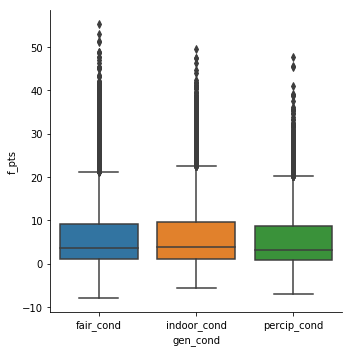

In [93]:
sb.catplot(x='gen_cond', y='f_pts', kind='box', data=df_eda)

In [91]:
#list out all of the columns
for i in df_eda.columns:
    print(i)

pk
gid
seas
wk
player
fname
lname
full_name
team
pos1
nflid
pa
pc
py
ints
tdp
ra
sra
ry
tdr
fuml
trg
rec
recy
tdrec
ret
rety
tdret
exp
height
weight
dob
dv
forty
bench
vertical
broad
shuttle
cone
arm
hand
cusum_pa
cusum_pc
cusum_py
cusum_ints
cusum_tdp
cusum_ra
cusum_sra
cusum_ry
cusum_tdr
cusum_fuml
cusum_trg
cusum_rec
cusum_recy
cusum_tdrec
cusum_ret
cusum_rety
cusum_tdret
recent_pa
recent_pc
recent_py
recent_ints
recent_tdp
recent_ra
recent_sra
recent_ry
recent_tdr
recent_fuml
recent_trg
recent_rec
recent_recy
recent_tdrec
recent_ret
recent_rety
recent_tdret
career_comp_pct
career_td_to_int
career_yds_per_comp
recent_comp_pct
recent_td_to_int
recent_yds_per_comp
career_ryds_per_carry
career_carry_to_td
career_carry_to_fuml
recent_ryds_per_carry
recent_carry_to_td
recent_carry_to_fuml
career_catch_pct
career_yds_per_rec
career_rec_to_td
recent_catch_pct
recent_yds_per_rec
recent_rec_to_td
career_avg_ret
career_ret_to_td
recent_avg_ret
recent_ret_to_td
age
v
h
day
cond
stad
temp
wdir


#### Explore the underdog feature

In [472]:
#create new column of binary underdog
df_eda['udog_bin'] = df_eda['team'].eq(df_eda['udog'])
#convert to category
df_eda['udog_bin'] = df_eda['udog_bin'].astype('category')

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


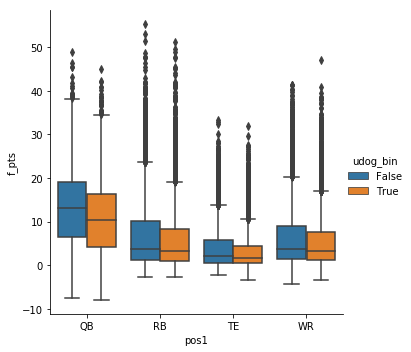

In [473]:
sb.catplot(x='pos1', y='f_pts', hue='udog_bin', kind='box', data=df_eda)

In [474]:
df_eda.groupby(['pos1', 'udog_bin'], as_index=True).agg({'f_pts': ['min', 'max', 'mean', 'median']})

f_pts                             
                    min    max       mean     median
pos1 udog_bin                                       
QB   False    -7.440000  48.82  13.065708  13.070000
     True     -7.990000  44.99  10.789780  10.320000
RB   False    -2.800000  55.40   6.609011   3.700000
     True     -2.800000  51.20   5.627840   3.200000
TE   False    -2.200000  33.40   3.753956   2.000000
     True     -3.300000  32.00   3.203514   1.600000
WR   False    -4.342857  41.40   5.865394   3.771429
     True     -3.500000  47.10   5.165432   3.300000

#### Analyze the cumulative stat features

In [94]:
#remove rows where it is NA due to the lag
df_eda_roll = df_eda[~df_eda.loc[:, 'cusum_pa':'recent_tdret'].isna().any(axis=1)]

In [98]:
#career passing versus next week's fantasy points
df_eda_roll.loc[(df_eda_roll['pos1']=='QB') & (df_eda_roll['cusum_pa'] > 100), ['f_pts', 'recent_py']].corr(method='pearson')

,f_pts,recent_py
f_pts,1.000000,0.267971
recent_py,0.267971,1.000000


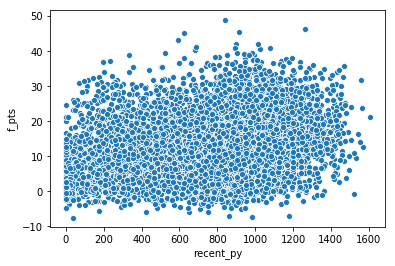

In [97]:
sb.scatterplot(x='recent_py', y='f_pts',
               data=df_eda_roll.loc[(df_eda_roll['pos1']=='QB') & (df_eda_roll['cusum_pa'] > 100), :])

### Game features

In [100]:
df_eda_roll.groupby(['pos1', 'gen_cond']).agg({'f_pts': ['median', 'count']})

f_pts       
                     median  count
pos1 gen_cond                     
QB   fair_cond    12.255000   6350
     indoor_cond  13.430000   2171
     percip_cond  10.720000    831
RB   fair_cond     3.600000  17711
     indoor_cond   3.900000   5800
     percip_cond   3.400000   2273
TE   fair_cond     2.000000  10169
     indoor_cond   1.900000   3491
     percip_cond   1.700000   1267
WR   fair_cond     3.600000  22709
     indoor_cond   3.942857   7839
     percip_cond   3.114286   2877

## Write the dataframe for model building

In [79]:
#write final dataframe to CSV
full_df.to_csv('C:/Users/Joe/Projects/fantasy_football/data/full_data.csv', index=False, header=True, na_rep=np.NaN)

Wall time: 0 ns


In [80]:
#write final dataframe to pickle file
full_df.to_pickle('C:/Users/Joe/Projects/fantasy_football/data/full_data.pkl')